# UZOP Projekt

Early Predictor for Student Success Based on Behavioural and Demographical Indicators

# Učitavanje potrebnih paketa

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.multiclass import OneVsRestClassifier
from scipy.stats import chi2_contingency

# Učitavanje podataka


In [46]:
assessments = pd.read_csv("assessments.csv", sep = ",")
courses = pd.read_csv("courses.csv", sep = ",")
studentAssessment = pd.read_csv("studentAssessment.csv", sep = ",")
studentInfo = pd.read_csv("studentInfo.csv", sep = ",")
studentRegistration = pd.read_csv("studentRegistration.csv", sep = ",")
studentVle = pd.read_csv("studentVle.csv", sep = ",")
vle = pd.read_csv("vle.csv", sep = ",")

# Početni pregled podataka

### Pregled podataka

In [9]:
assessments.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0
1,AAA,2013J,1753,TMA,54.0,20.0
2,AAA,2013J,1754,TMA,117.0,20.0
3,AAA,2013J,1755,TMA,166.0,20.0
4,AAA,2013J,1756,TMA,215.0,30.0


In [10]:
courses.head()

,code_module,code_presentation,module_presentation_length
0,AAA,2013J,268
1,AAA,2014J,269
2,BBB,2013J,268
3,BBB,2014J,262
4,BBB,2013B,240


In [11]:
studentAssessment.head()

,id_assessment,id_student,date_submitted,is_banked,score
0,1752,11391,18,0,78.0
1,1752,28400,22,0,70.0
2,1752,31604,17,0,72.0
3,1752,32885,26,0,69.0
4,1752,38053,19,0,79.0


In [12]:
studentInfo.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass


In [13]:
studentRegistration.head()

,code_module,code_presentation,id_student,date_registration,date_unregistration
0,AAA,2013J,11391,-159.0,NaN
1,AAA,2013J,28400,-53.0,NaN
2,AAA,2013J,30268,-92.0,12.0
3,AAA,2013J,31604,-52.0,NaN
4,AAA,2013J,32885,-176.0,NaN


In [14]:
studentVle.head()

,code_module,code_presentation,id_student,id_site,date,sum_click
0,AAA,2013J,28400,546652,-10,4
1,AAA,2013J,28400,546652,-10,1
2,AAA,2013J,28400,546652,-10,1
3,AAA,2013J,28400,546614,-10,11
4,AAA,2013J,28400,546714,-10,1


In [15]:
vle.head()

,id_site,code_module,code_presentation,activity_type,week_from,week_to
0,546943,AAA,2013J,resource,NaN,NaN
1,546712,AAA,2013J,oucontent,NaN,NaN
2,546998,AAA,2013J,resource,NaN,NaN
3,546888,AAA,2013J,url,NaN,NaN
4,547035,AAA,2013J,resource,NaN,NaN


### Broj zapisa i značajki

In [38]:
assessments.shape

(206, 6)

In [31]:
courses.shape

(22, 3)

In [32]:
studentAssessment.shape

(173912, 5)

In [33]:
studentInfo.shape

(32593, 12)

In [34]:
studentRegistration.shape

(32593, 5)

In [35]:
studentVle.shape

(10655280, 6)

In [36]:
vle.shape

(6364, 6)

# Pregled vrsta značajki

In [63]:
assessments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206 entries, 0 to 205
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   code_module        206 non-null    object 
 1   code_presentation  206 non-null    object 
 2   id_assessment      206 non-null    int64  
 3   assessment_type    206 non-null    object 
 4   date               195 non-null    float64
 5   weight             206 non-null    float64
dtypes: float64(2), int64(1), object(3)
memory usage: 9.8+ KB


In [64]:
courses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 3 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   code_module                 22 non-null     object
 1   code_presentation           22 non-null     object
 2   module_presentation_length  22 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 660.0+ bytes


In [66]:
studentAssessment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173912 entries, 0 to 173911
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id_assessment   173912 non-null  int64  
 1   id_student      173912 non-null  int64  
 2   date_submitted  173912 non-null  int64  
 3   is_banked       173912 non-null  int64  
 4   score           173739 non-null  float64
dtypes: float64(1), int64(4)
memory usage: 6.6 MB


In [67]:
studentInfo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   code_module           32593 non-null  object
 1   code_presentation     32593 non-null  object
 2   id_student            32593 non-null  int64 
 3   gender                32593 non-null  object
 4   region                32593 non-null  object
 5   highest_education     32593 non-null  object
 6   imd_band              31482 non-null  object
 7   age_band              32593 non-null  object
 8   num_of_prev_attempts  32593 non-null  int64 
 9   studied_credits       32593 non-null  int64 
 10  disability            32593 non-null  object
 11  final_result          32593 non-null  object
dtypes: int64(3), object(9)
memory usage: 3.0+ MB


In [68]:
studentRegistration.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   code_module          32593 non-null  object 
 1   code_presentation    32593 non-null  object 
 2   id_student           32593 non-null  int64  
 3   date_registration    32548 non-null  float64
 4   date_unregistration  10072 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 1.2+ MB


In [69]:
studentVle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10655280 entries, 0 to 10655279
Data columns (total 6 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   code_module        object
 1   code_presentation  object
 2   id_student         int64 
 3   id_site            int64 
 4   date               int64 
 5   sum_click          int64 
dtypes: int64(4), object(2)
memory usage: 487.8+ MB


In [70]:
vle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6364 entries, 0 to 6363
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id_site            6364 non-null   int64  
 1   code_module        6364 non-null   object 
 2   code_presentation  6364 non-null   object 
 3   activity_type      6364 non-null   object 
 4   week_from          1121 non-null   float64
 5   week_to            1121 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 298.4+ KB


# Deskriptivna statistika

In [40]:
assessments.describe(include = "all")

,code_module,code_presentation,id_assessment,assessment_type,date,weight
count,206,206,206.000000,206,195.000000,206.000000
unique,7,4,NaN,3,NaN,NaN
top,FFF,2014J,NaN,TMA,NaN,NaN
freq,52,57,NaN,106,NaN,NaN
mean,NaN,NaN,26473.975728,NaN,145.005128,20.873786
std,NaN,NaN,10098.625521,NaN,76.001119,30.384224
min,NaN,NaN,1752.000000,NaN,12.000000,0.000000
25%,NaN,NaN,15023.250000,NaN,71.000000,0.000000
50%,NaN,NaN,25364.500000,NaN,152.000000,12.500000
75%,NaN,NaN,34891.750000,NaN,222.000000,24.250000


In [42]:
courses.describe(include = "all")

,code_module,code_presentation,module_presentation_length
count,22,22,22.000000
unique,7,4,NaN
top,BBB,2014J,NaN
freq,4,7,NaN
mean,NaN,NaN,255.545455
std,NaN,NaN,13.654677
min,NaN,NaN,234.000000
25%,NaN,NaN,241.000000
50%,NaN,NaN,261.500000
75%,NaN,NaN,268.000000


In [46]:
studentAssessment.describe(include = "all")

,id_assessment,id_student,date_submitted,is_banked,score
count,173912.000000,1.739120e+05,173912.000000,173912.000000,173739.000000
mean,26553.803556,7.051507e+05,116.032942,0.010977,75.799573
std,8829.784254,5.523952e+05,71.484148,0.104194,18.798107
min,1752.000000,6.516000e+03,-11.000000,0.000000,0.000000
25%,15022.000000,5.044290e+05,51.000000,0.000000,65.000000
50%,25359.000000,5.852080e+05,116.000000,0.000000,80.000000
75%,34883.000000,6.344980e+05,173.000000,0.000000,90.000000
max,37443.000000,2.698588e+06,608.000000,1.000000,100.000000


In [48]:
studentInfo.describe(include = "all")

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
count,32593,32593,3.259300e+04,32593,32593,32593,31482,32593,32593.000000,32593.000000,32593,32593
unique,7,4,NaN,2,13,5,10,3,NaN,NaN,2,4
top,BBB,2014J,NaN,M,Scotland,A Level or Equivalent,20-30%,0-35,NaN,NaN,N,Pass
freq,7909,11260,NaN,17875,3446,14045,3654,22944,NaN,NaN,29429,12361
mean,NaN,NaN,7.066877e+05,NaN,NaN,NaN,NaN,NaN,0.163225,79.758691,NaN,NaN
std,NaN,NaN,5.491673e+05,NaN,NaN,NaN,NaN,NaN,0.479758,41.071900,NaN,NaN
min,NaN,NaN,3.733000e+03,NaN,NaN,NaN,NaN,NaN,0.000000,30.000000,NaN,NaN
25%,NaN,NaN,5.085730e+05,NaN,NaN,NaN,NaN,NaN,0.000000,60.000000,NaN,NaN
50%,NaN,NaN,5.903100e+05,NaN,NaN,NaN,NaN,NaN,0.000000,60.000000,NaN,NaN
75%,NaN,NaN,6.444530e+05,NaN,NaN,NaN,NaN,NaN,0.000000,120.000000,NaN,NaN


In [50]:
studentRegistration.describe(include = "all")

,code_module,code_presentation,id_student,date_registration,date_unregistration
count,32593,32593,3.259300e+04,32548.000000,10072.000000
unique,7,4,NaN,NaN,NaN
top,BBB,2014J,NaN,NaN,NaN
freq,7909,11260,NaN,NaN,NaN
mean,NaN,NaN,7.066877e+05,-69.411300,49.757645
std,NaN,NaN,5.491673e+05,49.260522,82.460890
min,NaN,NaN,3.733000e+03,-322.000000,-365.000000
25%,NaN,NaN,5.085730e+05,-100.000000,-2.000000
50%,NaN,NaN,5.903100e+05,-57.000000,27.000000
75%,NaN,NaN,6.444530e+05,-29.000000,109.000000


In [52]:
studentVle.describe(include = "all")

,code_module,code_presentation,id_student,id_site,date,sum_click
count,10655280,10655280,1.065528e+07,1.065528e+07,1.065528e+07,1.065528e+07
unique,7,4,NaN,NaN,NaN,NaN
top,FFF,2014J,NaN,NaN,NaN,NaN
freq,4014499,3619452,NaN,NaN,NaN,NaN
mean,NaN,NaN,7.333336e+05,7.383234e+05,9.517400e+01,3.716946e+00
std,NaN,NaN,5.827060e+05,1.312196e+05,7.607130e+01,8.849047e+00
min,NaN,NaN,6.516000e+03,5.267210e+05,-2.500000e+01,1.000000e+00
25%,NaN,NaN,5.077430e+05,6.735190e+05,2.500000e+01,1.000000e+00
50%,NaN,NaN,5.882360e+05,7.300690e+05,8.600000e+01,2.000000e+00
75%,NaN,NaN,6.464840e+05,8.770300e+05,1.560000e+02,3.000000e+00


In [54]:
vle.describe(include = "all")

,id_site,code_module,code_presentation,activity_type,week_from,week_to
count,6.364000e+03,6364,6364,6364,1121.000000,1121.000000
unique,NaN,7,4,20,NaN,NaN
top,NaN,FFF,2013J,resource,NaN,NaN
freq,NaN,1967,1772,2660,NaN,NaN
mean,7.260991e+05,NaN,NaN,NaN,15.204282,15.214987
std,1.283151e+05,NaN,NaN,NaN,8.792865,8.779806
min,5.267210e+05,NaN,NaN,NaN,0.000000,0.000000
25%,6.615928e+05,NaN,NaN,NaN,8.000000,8.000000
50%,7.300965e+05,NaN,NaN,NaN,15.000000,15.000000
75%,8.140162e+05,NaN,NaN,NaN,22.000000,22.000000


# Monotoni atributi

In [4]:
assessments.nunique()

code_module            7
code_presentation      4
id_assessment        206
assessment_type        3
date                  74
weight                24
dtype: int64

In [56]:
courses.nunique()

code_module                   7
code_presentation             4
module_presentation_length    7
dtype: int64

In [58]:
studentAssessment.nunique()

id_assessment       188
id_student        23369
date_submitted      312
is_banked             2
score               101
dtype: int64

In [59]:
studentInfo.nunique()

code_module                 7
code_presentation           4
id_student              28785
gender                      2
region                     13
highest_education           5
imd_band                   10
age_band                    3
num_of_prev_attempts        7
studied_credits            61
disability                  2
final_result                4
dtype: int64

In [60]:
studentRegistration.nunique()

code_module                7
code_presentation          4
id_student             28785
date_registration        332
date_unregistration      416
dtype: int64

In [61]:
studentVle.nunique()

code_module              7
code_presentation        4
id_student           26074
id_site               6268
date                   295
sum_click              498
dtype: int64

In [62]:
vle.nunique()

id_site              6364
code_module             7
code_presentation       4
activity_type          20
week_from              30
week_to                30
dtype: int64

 Monotoni podaci su identifikatori kojima su podaci povezani te ih nećemo obrisati.

# Nedostajući podatci

In [3]:
assessments.isna().sum()

code_module           0
code_presentation     0
id_assessment         0
assessment_type       0
date                 11
weight                0
dtype: int64

In [4]:
#TODO

# Ubacivanje srednje vrijednosti za nedostajuće podatke značajke "date"
assessments.loc[assessments.date.isna(),'date'] = assessments.loc[:,'date'].mean()

In [7]:
courses.isna().sum()

code_module                   0
code_presentation             0
module_presentation_length    0
dtype: int64

In [8]:
studentAssessment.isna().sum()

id_assessment       0
id_student          0
date_submitted      0
is_banked           0
score             173
dtype: int64

In [47]:
# Ubacivanje srednje vrijednosti za nedostajuće podatke značajke "score"
studentAssessment.loc[studentAssessment.score.isna(),'score'] = studentAssessment.loc[:,'score'].mean()

In [10]:
studentInfo.isna().sum()

code_module                0
code_presentation          0
id_student                 0
gender                     0
region                     0
highest_education          0
imd_band                1111
age_band                   0
num_of_prev_attempts       0
studied_credits            0
disability                 0
final_result               0
dtype: int64

In [6]:
# izbaci stupac "imd_band"
studentInfo.drop(['imd_band'], axis=1, inplace=True)

In [12]:
studentRegistration.isna().sum()

code_module                0
code_presentation          0
id_student                 0
date_registration         45
date_unregistration    22521
dtype: int64

In [48]:
# Ubacivanje srednje vrijednosti za nedostajuće podatke značajke "date_registration"
studentRegistration.loc[studentRegistration.date_registration.isna(),'date_registration'] = studentRegistration.loc[:,'date_registration'].mean()

# Značajku "date_unregistration" čemo ostaviti jer njena prazna vrijednost označava da student nije završio.

In [14]:
studentVle.isna().sum()

code_module          0
code_presentation    0
id_student           0
id_site              0
date                 0
sum_click            0
dtype: int64

In [15]:
vle.isna().sum()

id_site                 0
code_module             0
code_presentation       0
activity_type           0
week_from            5243
week_to              5243
dtype: int64

In [8]:
# izbaci stupac "week_from"
vle.drop(['week_from'], axis=1, inplace=True)

# izbaci stupac "week_to"
vle.drop(['week_to'], axis=1, inplace=True)

# Stršeći podatci

### Assessments

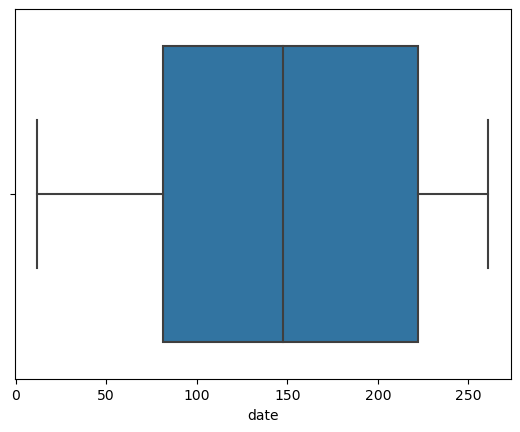

In [19]:
# Box plot za "date"
sns.boxplot(x=assessments['date'])
plt.show()

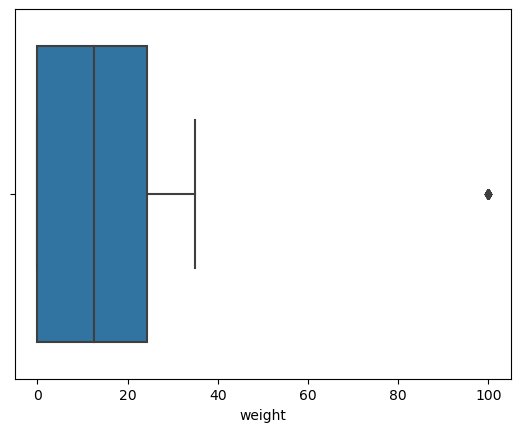

In [20]:
# Box plot za "weight"
sns.boxplot(x=assessments['weight'])
plt.show()

### Courses

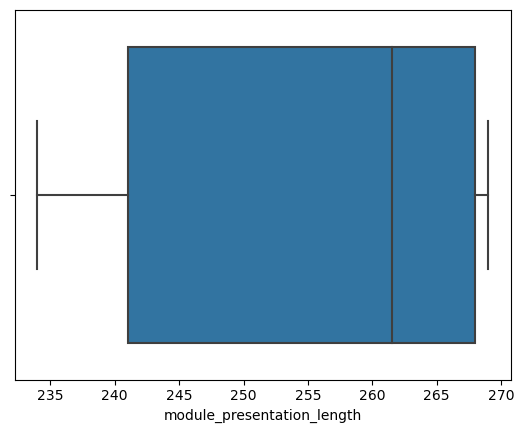

In [21]:
# Box plot za "module_presentation_length"
sns.boxplot(x=courses['module_presentation_length'])
plt.show()

### StudentAssessments

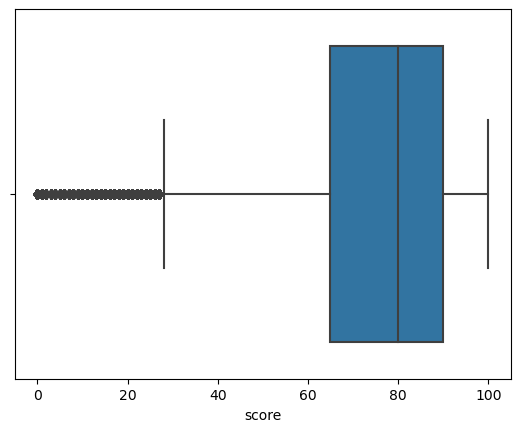

In [23]:
# Box plot za "score"
sns.boxplot(x=studentAssessment['score'])
plt.show()

### StudentInfo

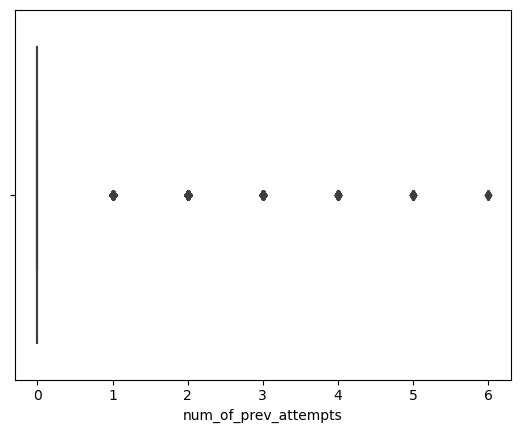

In [24]:
# Box plot za "num_of_prev_attempts"
sns.boxplot(x=studentInfo['num_of_prev_attempts'])
plt.show()

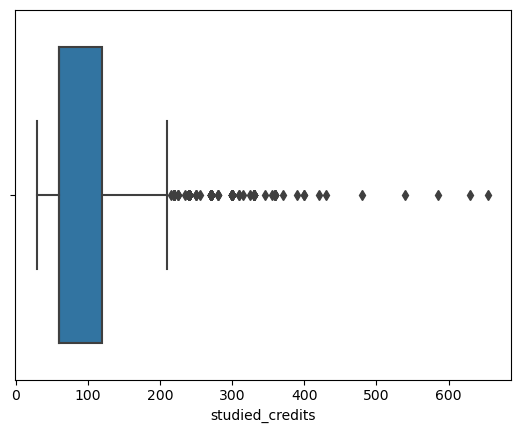

In [25]:
# Box plot za "studied_credits"
sns.boxplot(x=studentInfo['studied_credits'])
plt.show()

### StudentRegistration

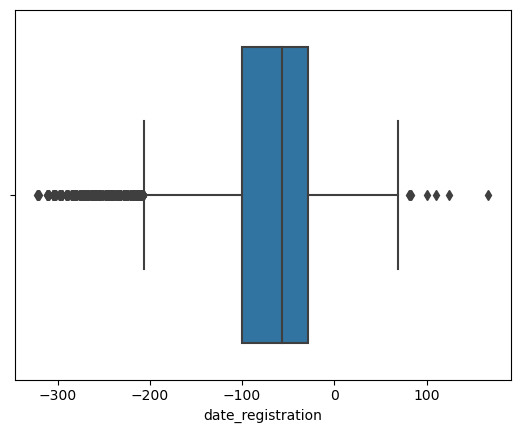

In [26]:
# Box plot za "date_registration"
sns.boxplot(x=studentRegistration['date_registration'])
plt.show()

### StudentVle

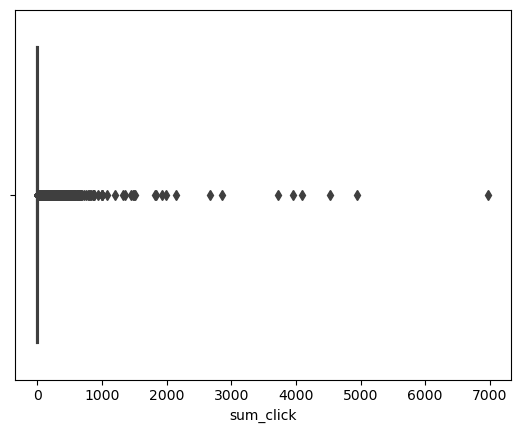

In [27]:
# Box plot za "sum_click"
sns.boxplot(x=studentVle['sum_click'])
plt.show()

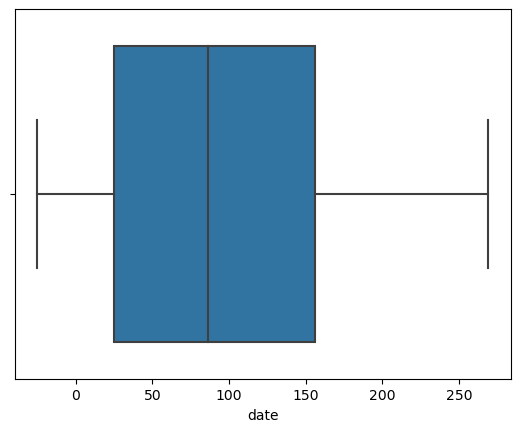

In [28]:
# Box plot za "date"
sns.boxplot(x=studentVle['date'])
plt.show()

# Vizualizacija

/Users/marko/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


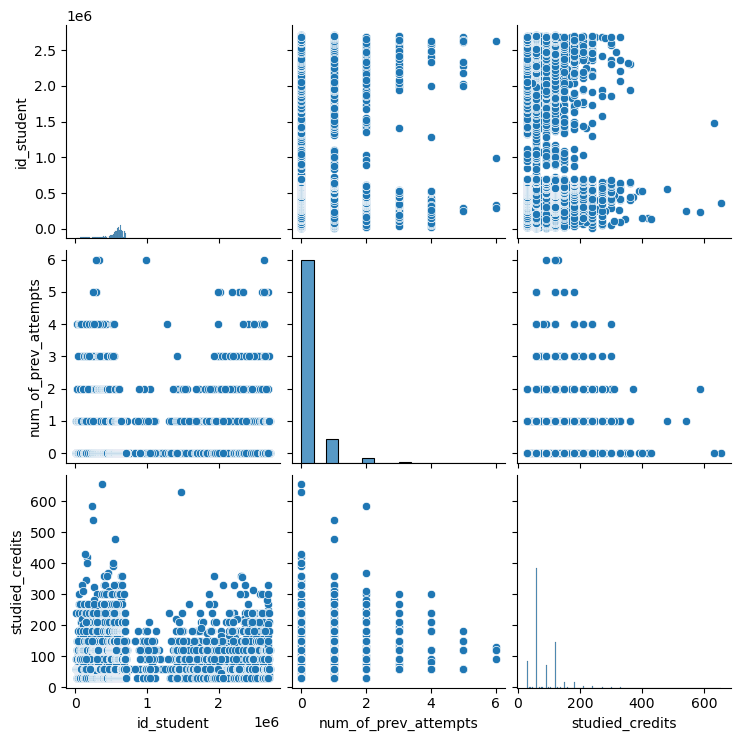

In [30]:
sns.pairplot(studentInfo)
plt.show()

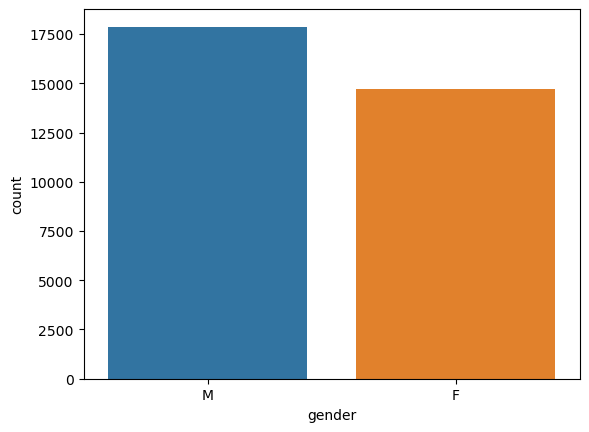

In [31]:
sns.countplot(x='gender', data=studentInfo)
plt.show()

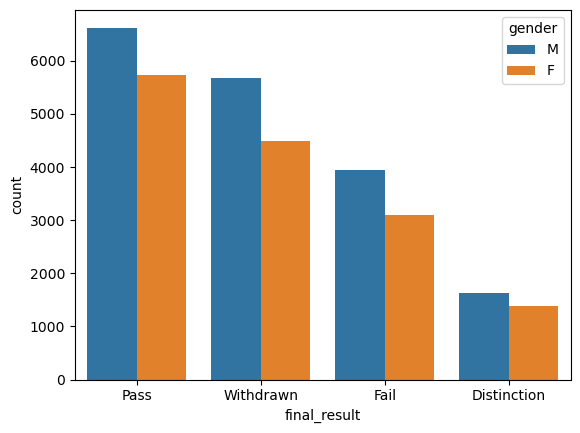

In [10]:
sns.countplot(x='final_result', hue='gender', data=studentInfo)
plt.show()

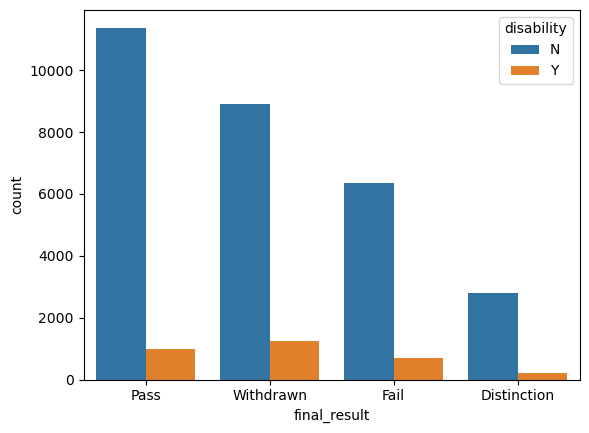

In [18]:
sns.countplot(x='final_result', hue='disability', data=studentInfo)
plt.show()

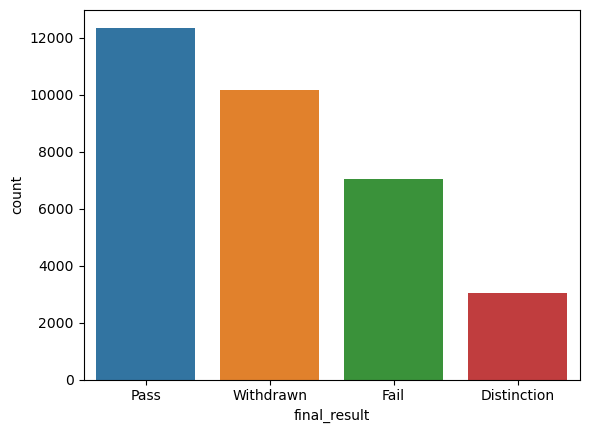

In [36]:
sns.countplot(x='final_result', data=studentInfo)
plt.show()

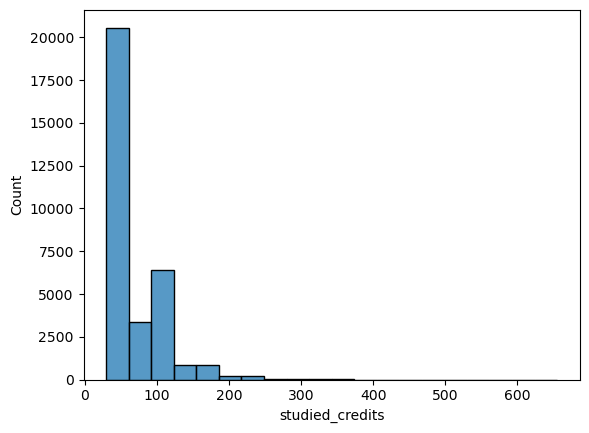

In [35]:
sns.histplot(x='studied_credits', data=studentInfo, bins=20)
plt.show()

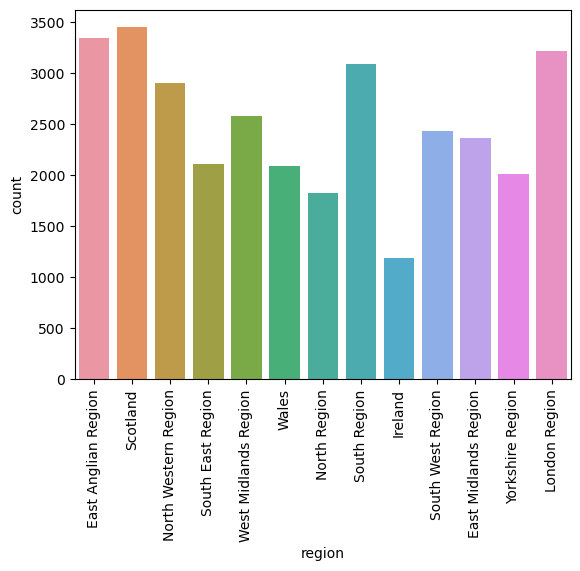

In [16]:
sns.countplot(x='region', data=studentInfo)
plt.xticks(rotation=90)
plt.show()

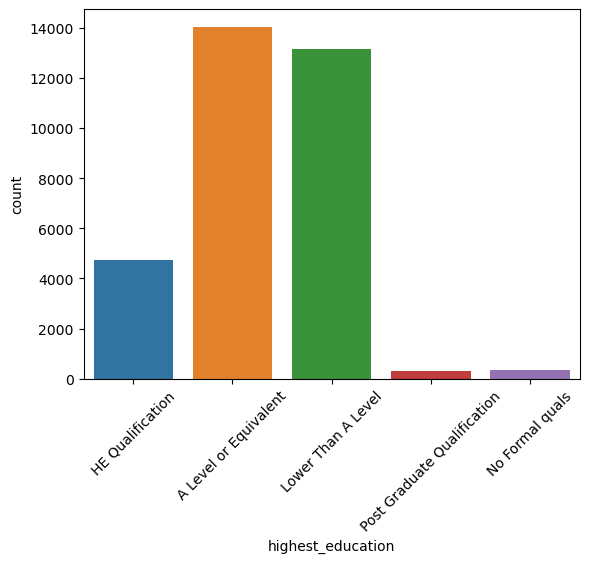

In [23]:
sns.countplot(x='highest_education', data=studentInfo)
plt.xticks(rotation=45)
plt.show()

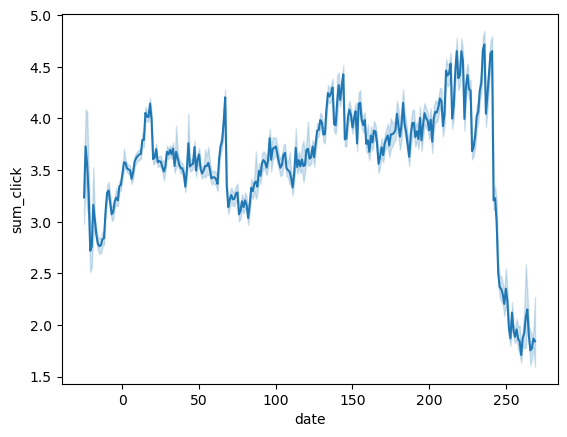

In [10]:
sns.lineplot(x='date', y='sum_click', data=studentVle)
plt.show()

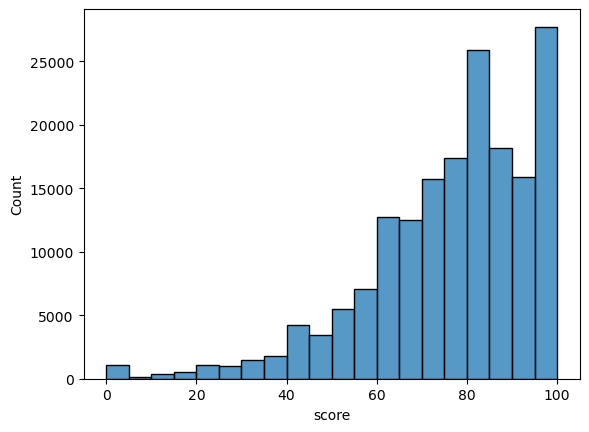

In [12]:
sns.histplot(x='score', data=studentAssessment, bins=20)
plt.show()

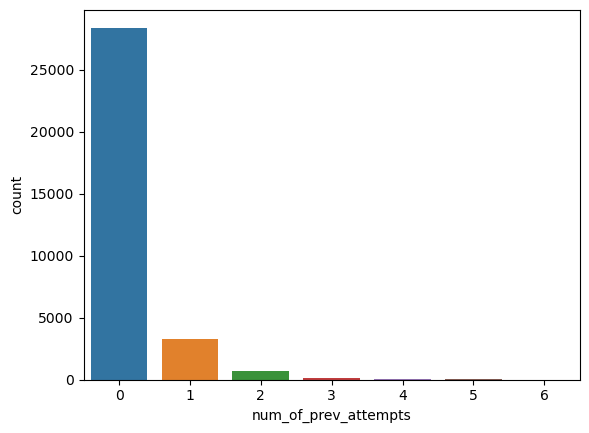

In [40]:
sns.countplot(x='num_of_prev_attempts', data=studentInfo)
plt.show()

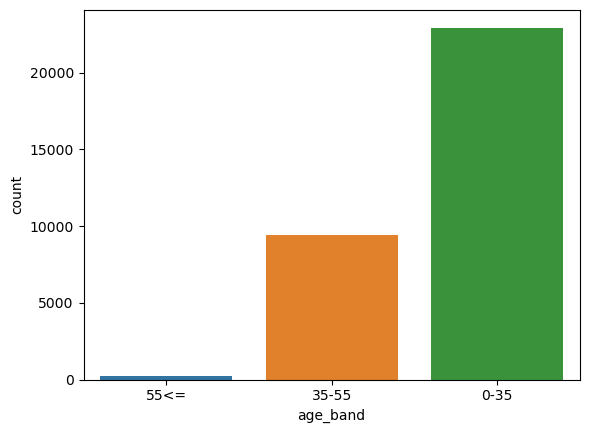

In [54]:
sns.countplot(x='age_band', data=studentInfo)
plt.show()

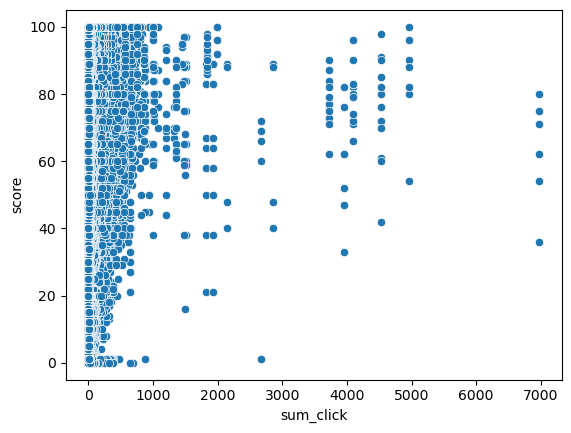

In [57]:
merged_scores_clicks = pd.merge(studentVle, studentAssessment[['id_student', 'score']], on='id_student', how='inner')

sns.scatterplot(x='sum_click', y='score', data=merged_scores_clicks)
plt.show()

# Replikacija rezultata


### Podaci

In [24]:
assessments = pd.read_csv("assessments.csv", sep = ",")
courses = pd.read_csv("courses.csv", sep = ",")
studentAssessment = pd.read_csv("studentAssessment.csv", sep = ",")
studentInfo = pd.read_csv("studentInfo.csv", sep = ",")
studentRegistration = pd.read_csv("studentRegistration.csv", sep = ",")
studentVle = pd.read_csv("studentVle.csv", sep = ",")
vle = pd.read_csv("vle.csv", sep = ",")

### Priprema potrebnih podataka

In [25]:
# Ubacivanje srednje vrijednosti za nedostajuće podatke značajke "score"
studentAssessment.loc[studentAssessment.score.isna(),'score'] = studentAssessment.loc[:,'score'].mean()

# Ubacivanje srednje vrijednosti za nedostajuće podatke značajke "date_registration"
studentRegistration.loc[studentRegistration.date_registration.isna(),'date_registration'] = studentRegistration.loc[:,'date_registration'].mean()


## Priprema varijabli za klasifikaciju

### First Assignment Mark

In [26]:
#first_assignment_mark = studentAssessment.copy()[['id_student', 'score']]
#first_assignment_mark.rename(columns={'score': 'First_Assignment_Mark'}, inplace=True)

#first_assignment_mark = studentAssessment.groupby('id_student')['score'].mean().reset_index()
#first_assignment_mark.rename(columns={'score': 'First_Assignment_Mark'}, inplace=True)

first_assignment_mark = assessments.loc[assessments.groupby(['code_module', 'code_presentation']).date.idxmin()].merge(studentAssessment, on=['id_assessment'])[['id_student', 'code_module', 'code_presentation', 'score']]


### Educational Level

In [27]:
studentInfo['Educational_Level'] = studentInfo['highest_education']


### Clicks Till Course Starts

In [28]:
#clicks_till_course_starts_df = studentVle.groupby(['code_module', 'code_presentation', 'id_student'])['sum_click'].sum().reset_index()
clicks_till_course_starts_df = studentVle.loc[studentVle['date'] < 0].groupby(['code_module', 'code_presentation', 'id_student'])['sum_click'].sum().reset_index()


### Registration Date

In [29]:
studentRegistration['Registration_Date'] = studentRegistration['date_registration']


### Merge svih varijabli

In [30]:
analysis_df = first_assignment_mark.merge(clicks_till_course_starts_df, on=['id_student', 'code_module', 'code_presentation'])
analysis_df = analysis_df.merge(studentRegistration[['id_student', 'code_module', 'code_presentation', 'date_registration']], on=['id_student', 'code_module', 'code_presentation'])
analysis_df = analysis_df.merge(studentInfo[['id_student', 'code_module', 'code_presentation', 'Educational_Level', 'age_band', 'disability', 'gender', 'num_of_prev_attempts']], on=['id_student', 'code_module', 'code_presentation'])
analysis_df


,id_student,code_module,code_presentation,score,sum_click,date_registration,Educational_Level,age_band,disability,gender,num_of_prev_attempts
0,11391,AAA,2013J,78.0,98,-159.0,HE Qualification,55<=,N,M,0
1,28400,AAA,2013J,70.0,215,-53.0,HE Qualification,35-55,N,F,0
2,31604,AAA,2013J,72.0,169,-52.0,A Level or Equivalent,35-55,N,F,0
3,32885,AAA,2013J,69.0,295,-176.0,Lower Than A Level,0-35,N,F,0
4,38053,AAA,2013J,79.0,277,-110.0,A Level or Equivalent,35-55,N,M,0
...,...,...,...,...,...,...,...,...,...,...,...
21053,521631,GGG,2014J,75.0,19,-14.0,Lower Than A Level,35-55,N,F,0
21054,532862,GGG,2014J,75.0,23,-3.0,Lower Than A Level,35-55,N,F,0
21055,534672,GGG,2014J,70.0,2,-10.0,A Level or Equivalent,35-55,N,F,0
21056,546286,GGG,2014J,69.0,6,-10.0,A Level or Equivalent,0-35,N,M,0


In [31]:
# merge podataka sa final_result
data = pd.merge(analysis_df, studentInfo[['id_student', 'final_result', 'code_module', 'code_presentation']], on=['id_student', 'code_module', 'code_presentation'])
data

,id_student,code_module,code_presentation,score,sum_click,date_registration,Educational_Level,age_band,disability,gender,num_of_prev_attempts,final_result
0,11391,AAA,2013J,78.0,98,-159.0,HE Qualification,55<=,N,M,0,Pass
1,28400,AAA,2013J,70.0,215,-53.0,HE Qualification,35-55,N,F,0,Pass
2,31604,AAA,2013J,72.0,169,-52.0,A Level or Equivalent,35-55,N,F,0,Pass
3,32885,AAA,2013J,69.0,295,-176.0,Lower Than A Level,0-35,N,F,0,Pass
4,38053,AAA,2013J,79.0,277,-110.0,A Level or Equivalent,35-55,N,M,0,Pass
...,...,...,...,...,...,...,...,...,...,...,...,...
21053,521631,GGG,2014J,75.0,19,-14.0,Lower Than A Level,35-55,N,F,0,Pass
21054,532862,GGG,2014J,75.0,23,-3.0,Lower Than A Level,35-55,N,F,0,Fail
21055,534672,GGG,2014J,70.0,2,-10.0,A Level or Equivalent,35-55,N,F,0,Pass
21056,546286,GGG,2014J,69.0,6,-10.0,A Level or Equivalent,0-35,N,M,0,Distinction


# Pearson chi-square

In [32]:
contingency_table = pd.crosstab(data['final_result'], [data['Educational_Level'], data['age_band'], data['gender'], data['disability']])
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"P-value: {p_value}")

P-value: 1.8902205759290034e-141


# Label encoding

In [125]:
"""
label_encoder = LabelEncoder()
data['Educational_Level'] = label_encoder.fit_transform(data['Educational_Level'])
data['age_band'] = label_encoder.fit_transform(data['age_band'])
data['disability'] = label_encoder.fit_transform(data['disability'])
data['gender'] = label_encoder.fit_transform(data['gender'])
"""

"\nlabel_encoder = LabelEncoder()\ndata['Educational_Level'] = label_encoder.fit_transform(data['Educational_Level'])\ndata['age_band'] = label_encoder.fit_transform(data['age_band'])\ndata['disability'] = label_encoder.fit_transform(data['disability'])\ndata['gender'] = label_encoder.fit_transform(data['gender'])\n"

# One-hot encoding

In [33]:
# definiramo enkoder
encoder = OneHotEncoder(handle_unknown="ignore")
encoder.fit(data[['Educational_Level', 'age_band', 'disability', 'gender']])
# transformiramo podatke
data_tmp = encoder.transform(data[['Educational_Level', 'age_band', 'disability', 'gender',]])
data_tmp = pd.DataFrame(data_tmp.toarray(), columns=encoder.get_feature_names_out(['Educational_Level', 'age_band', 'disability', 'gender']))

# spoji podatke
data = pd.concat((data, data_tmp), axis=1)

# izbaci nenumeričke stupce - ~ u ovom slučaju označava "not", odnosno uvjet bi se čitao kao "columns not in ['Name', ...]"
data_tmp = data.loc[:, ~data.columns.isin(['id_student', 'code_module','code_presentation', 'Educational_Level', 'age_band', 'disability', 'gender'])].copy()
data_tmp

,score,sum_click,date_registration,num_of_prev_attempts,final_result,Educational_Level_A Level or Equivalent,Educational_Level_HE Qualification,Educational_Level_Lower Than A Level,Educational_Level_No Formal quals,Educational_Level_Post Graduate Qualification,age_band_0-35,age_band_35-55,age_band_55<=,disability_N,disability_Y,gender_F,gender_M
0,78.0,98,-159.0,0,Pass,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
1,70.0,215,-53.0,0,Pass,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,72.0,169,-52.0,0,Pass,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,69.0,295,-176.0,0,Pass,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
4,79.0,277,-110.0,0,Pass,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21053,75.0,19,-14.0,0,Pass,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
21054,75.0,23,-3.0,0,Fail,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
21055,70.0,2,-10.0,0,Pass,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
21056,69.0,6,-10.0,0,Distinction,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


### Korelacijski test

<Axes: >

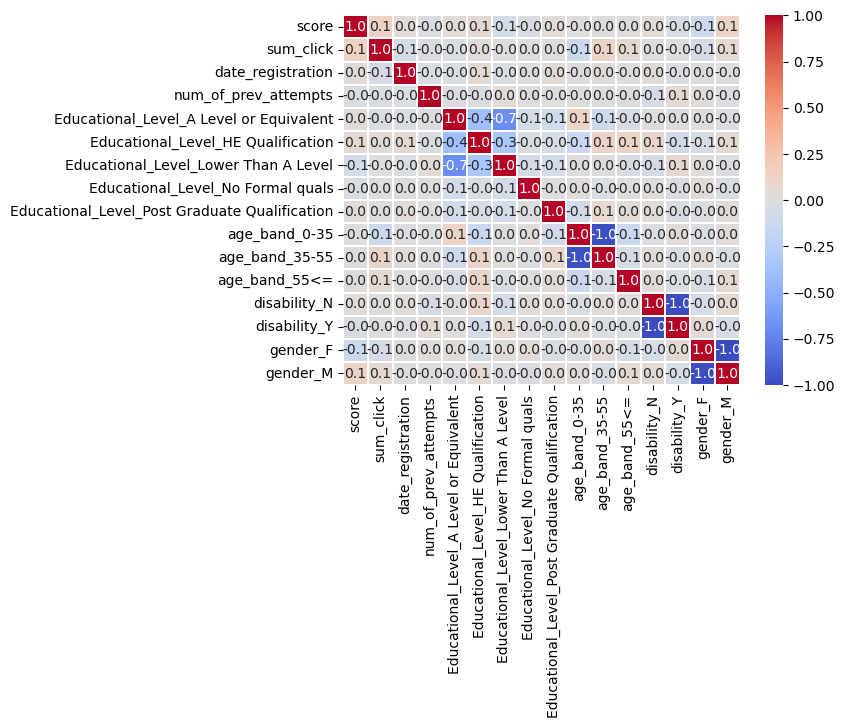

In [34]:
data_tmp.loc[:, ~data_tmp.columns.isin(['final_result'])].corr()

sns.heatmap(data_tmp.loc[:, data_tmp.columns != 'final_result'].corr(), annot=True, cmap='coolwarm', fmt=".1f", linewidths=0.1)


# Random Forest

Accuracy: 0.4498258942703387
Classification Report:
              precision    recall  f1-score   support

 Distinction       0.29      0.19      0.23       830
        Fail       0.29      0.20      0.24      1233
        Pass       0.52      0.72      0.60      3126
   Withdrawn       0.31      0.18      0.23      1129

    accuracy                           0.45      6318
   macro avg       0.35      0.32      0.32      6318
weighted avg       0.41      0.45      0.42      6318



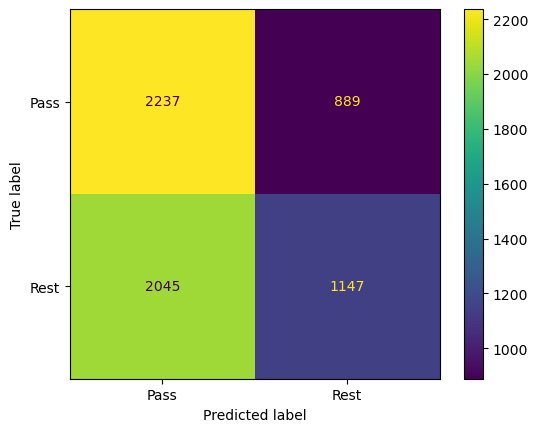

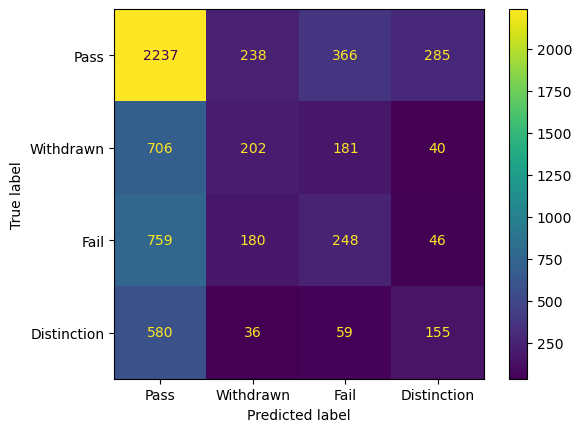

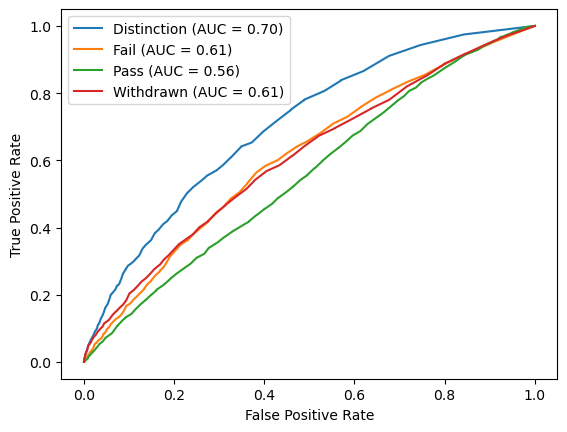

In [38]:
# odvajanje oznake klase
#X = data_tmp.loc[:, data_tmp.columns != 'final_result']
X = data_tmp.loc[:, ~data_tmp.columns.isin(['final_result', 'disability_N', 'disability_Y', 'num_of_prev_attempts'])]
y = data_tmp.loc[:, 'final_result']

# razdvoji podatke
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# instanciraj i treniraj model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# evaluiraj model
accuracy = accuracy_score(y_test, y_pred)
classification_report_result = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report_result)


# Confusion matrix
label_mapping = {
    'Pass': 'Pass',
    'Withdrawn': 'Rest',
    'Fail': 'Rest',
    'Distinction': 'Rest'
}
y_test_mapped = y_test.map(label_mapping)
y_pred_mapped = pd.Series(y_pred).map(label_mapping)

cm = confusion_matrix(y_test_mapped, y_pred_mapped, labels=pd.Series(list(label_mapping.values())).unique())
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pd.Series(list(label_mapping.values())).unique()).plot()
plt.show()

cm = confusion_matrix(y_test, y_pred, labels=y.unique())
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y.unique()).plot()
plt.show()


# Roc krivulja
# Predict probabilities for each class
y_score = model.predict_proba(X_test)

# Binarize the labels for the ROC curve
y_test_bin = label_binarize(y_test, classes=model.classes_)

# Plot ROC curve for each class
n_classes = len(model.classes_)

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model.classes_[i]} (AUC = {roc_auc:.2f})')
    
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Decision Tree

Accuracy: 0.3748021525799304
Classification Report:
              precision    recall  f1-score   support

 Distinction       0.24      0.25      0.25       830
        Fail       0.24      0.25      0.25      1233
        Pass       0.52      0.50      0.51      3126
   Withdrawn       0.24      0.24      0.24      1129

    accuracy                           0.37      6318
   macro avg       0.31      0.31      0.31      6318
weighted avg       0.38      0.37      0.38      6318



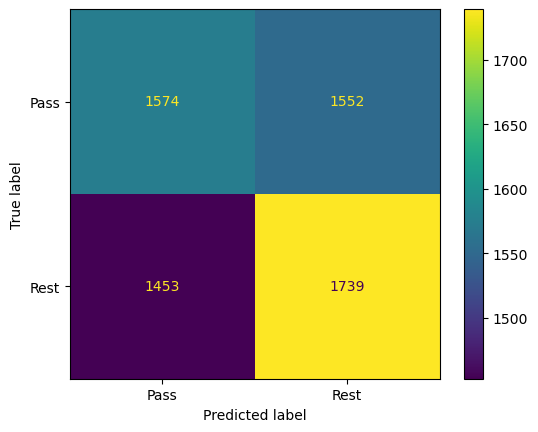

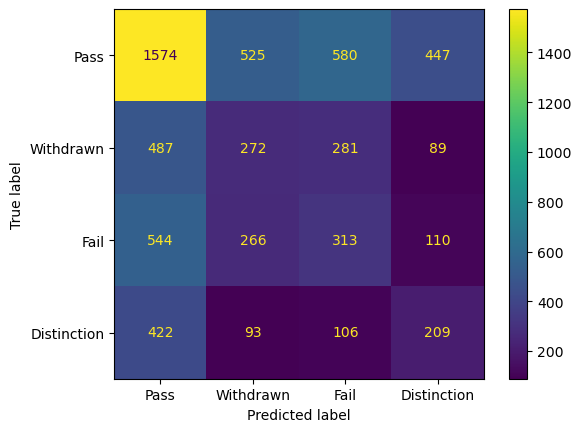

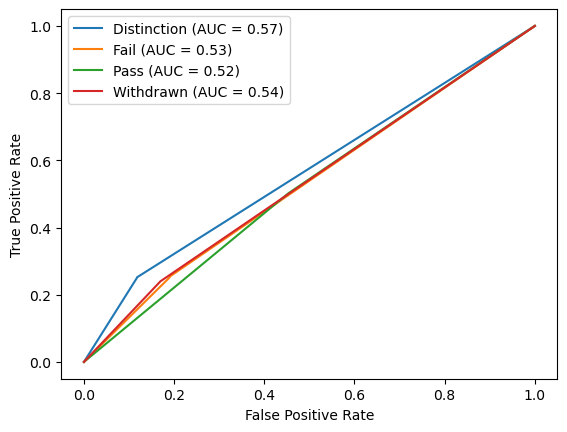

In [39]:
# odvajanje oznake klase
#X = data_tmp.loc[:, data_tmp.columns != 'final_result']
X = data_tmp.loc[:, ~data_tmp.columns.isin(['final_result', 'disability_N', 'disability_Y', 'num_of_prev_attempts'])]
y = data_tmp.loc[:, 'final_result']

# razdvoji podatke
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# instanciraj i treniraj model
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# evaluiraj model
accuracy = accuracy_score(y_test, y_pred)
classification_report_result = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report_result)


# Confusion matrix
label_mapping = {
    'Pass': 'Pass',
    'Withdrawn': 'Rest',
    'Fail': 'Rest',
    'Distinction': 'Rest'
}
y_test_mapped = y_test.map(label_mapping)
y_pred_mapped = pd.Series(y_pred).map(label_mapping)

cm = confusion_matrix(y_test_mapped, y_pred_mapped, labels=pd.Series(list(label_mapping.values())).unique())
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pd.Series(list(label_mapping.values())).unique()).plot()
plt.show()

cm = confusion_matrix(y_test, y_pred, labels=y.unique())
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y.unique()).plot()
plt.show()


# Roc krivulja
# Predict probabilities for each class
y_score = model.predict_proba(X_test)

# Check for NaNs in predicted probabilities
if np.isnan(y_score).any():
    y_score = np.nan_to_num(y_score)

# Binarize the labels for the ROC curve
y_test_bin = label_binarize(y_test, classes=model.classes_)

# Plot ROC curve for each class
n_classes = len(model.classes_)

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model.classes_[i]} (AUC = {roc_auc:.2f})')
    
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()